# implement 

### References
- WSABIE: Scaling Up To Large Vocabulary Image Annotation http://www.thespermwhale.com/jaseweston/papers/wsabie-ijcai.pdf
- Learning to Rank Recommendations with the k-Order Statistic Loss https://research.google.com/pubs/pub41534.html

### Data
- Movielens 100k https://grouplens.org/datasets/movielens/100k/
- README - http://files.grouplens.org/datasets/movielens/ml-100k-README.txt

In [1]:
import os
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, diags
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, accuracy_score, roc_curve, roc_auc_score
from sklearn.utils.extmath import safe_sparse_dot
import time
import math

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [23]:
from warp import WARPNaive

In [24]:
dtype = np.float32

In [25]:
data_dir = "/Users/timwee/projects/datasets/movielens/ml-100k"

def load_data_from_f(fpath):
    # columns - user id | item id | rating | timestamp
    # user_id and item_id numbered consecutively from 1
    with open(fpath) as f:
        users, items, ratings = [], [], []
        max_user = -1
        max_item = -1
        for line in f:
            user_id, item_id, rating, ts = [int(tok) for tok in line.strip().split("\t")]
            # make it zero indexed
            user_id -= 1
            item_id -= 1
            max_user = max(max_user, user_id)
            max_item = max(max_item, item_id)
            users.append(user_id) 
            items.append(item_id)
            ratings.append(rating)
        return np.array(users), np.array(items), np.array(ratings), max_user, max_item


def train_and_test_data(data_dir, train_fname="ua.base", test_fname="ua.test", dtype=np.float32):
    trn_u, trn_i, trn_r, max_trn_u, max_trn_i = load_data_from_f(os.path.join(data_dir, train_fname))
    tst_u, tst_i, tst_r, max_tst_u, max_tst_i = load_data_from_f(os.path.join(data_dir, test_fname))
    num_rows = max(max_trn_u, max_tst_u) + 1
    num_cols = max(max_trn_i, max_tst_i) + 1
    return {"train" : coo_matrix((trn_r, (trn_u, trn_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr(), \
            "test" : coo_matrix((tst_r, (tst_u, tst_i)), shape=(num_rows, num_cols), dtype=dtype).tocsr()}
    

In [26]:
movielens = train_and_test_data(data_dir, dtype=dtype)
train, test = movielens["train"], movielens["test"]
num_users, num_items = train.shape
train.shape, test.shape

((943, 1682), (943, 1682))

# WARP

### learning rate decay

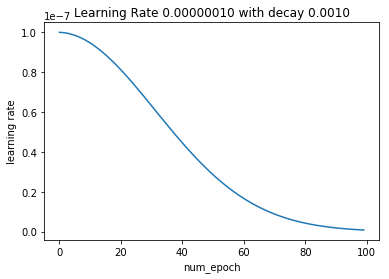

In [27]:
lrate = 1e-7
decay = 1e-3
lr_val = [lrate]
for i in range(1, 100):
    lr_val.append(lr_val[i-1] * (1. / (1. + (decay * i))))
plt.plot(np.arange(100), lr_val)
plt.xlabel("num_epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate %.8f with decay %.4f" % (lrate, decay))
plt.show()

# WARP class

In [39]:
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

durations = []
tst_warp_auc = []
tst_warp_prec5 = []

model = WARPNaive(lr=5e-5, item_reg=0.2, user_reg=0.2)
num_epochs = 15
for epoch in range(num_epochs):
    start = time.time()
    model.fit(train, reset=False)
    duration = time.time() - start
    durations.append(duration)    
    tst_auc = auc_score(model, test, train_interactions=train).mean()
    tst_prec5 = precision_at_k(model, test, train_interactions=train, k=5).mean()
    tst_warp_auc.append(tst_auc)
    tst_warp_prec5.append(tst_prec5)
    print("warp iteration %d took %.4f, auc: %.4f, p@5: %.4f" % (epoch, duration, tst_auc, tst_prec5))

initializing embeddings and biases
warp iteration 0 took 5.3159, auc: 0.7758, p@5: 0.0416
warp iteration 1 took 5.3709, auc: 0.7828, p@5: 0.0422
warp iteration 2 took 5.3771, auc: 0.7834, p@5: 0.0420
warp iteration 3 took 5.3669, auc: 0.7832, p@5: 0.0424
warp iteration 4 took 5.3411, auc: 0.7835, p@5: 0.0422
warp iteration 5 took 5.3987, auc: 0.7831, p@5: 0.0420
warp iteration 6 took 5.3792, auc: 0.7813, p@5: 0.0420
warp iteration 7 took 5.3622, auc: 0.7792, p@5: 0.0416
warp iteration 8 took 5.3859, auc: 0.7830, p@5: 0.0431
warp iteration 9 took 5.3519, auc: 0.7828, p@5: 0.0433
warp iteration 10 took 5.4335, auc: 0.7828, p@5: 0.0431
warp iteration 11 took 5.4157, auc: 0.7823, p@5: 0.0433
warp iteration 12 took 5.2855, auc: 0.7825, p@5: 0.0418
warp iteration 13 took 5.2486, auc: 0.7831, p@5: 0.0416
warp iteration 14 took 5.2687, auc: 0.7856, p@5: 0.0420


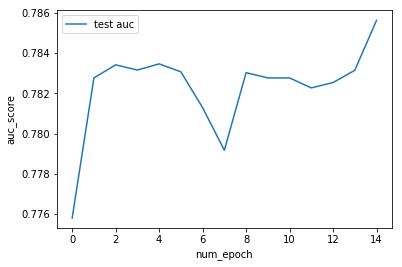

In [40]:
epoch_x = np.arange(num_epochs)
test_line, = plt.plot(epoch_x, tst_warp_auc, label="auc test")
#train_line, = plt.plot(epoch_x, auc_scores_train, label="auc train")
plt.legend([test_line], ["test auc"])
plt.xlabel("num_epoch")
plt.ylabel("auc_score")
plt.show()